## Fairness Analysis of Predictive Algorithms used in Criminal Justice to predict the likelihood of recidivism to determine bail decisions

### Importing Libraries

In [ ]:
#This is to import the library needed while some will be needed in the project.

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
label_encoder = LabelEncoder()
scaler = StandardScaler()
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings(action='ignore')

In [14]:
compas = pd.read_csv("cox-violent-parsed.csv")
compas.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event
0,1.0,miguel hernandez,miguel,hernandez,14/08/2013,Male,18/04/1947,69,Greater than 45,Other,0,1,0,0,0,-1.0,13/08/2013 6:03,14/08/2013 5:41,13011352CF10A,13/08/2013,NaN,1.0,(F3),Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,14/08/2013,Risk of Violence,1,Low,14/08/2013,07/07/2014,14/07/2014,0,0,327,0
1,2.0,miguel hernandez,miguel,hernandez,14/08/2013,Male,18/04/1947,69,Greater than 45,Other,0,1,0,0,0,-1.0,13/08/2013 6:03,14/08/2013 5:41,13011352CF10A,13/08/2013,NaN,1.0,(F3),Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,14/08/2013,Risk of Violence,1,Low,14/08/2013,07/07/2014,14/07/2014,0,334,961,0
2,3.0,michael ryan,michael,ryan,31/12/2014,Male,06/02/1985,31,25 - 45,Caucasian,0,5,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,5,Medium,31/12/2014,Risk of Violence,2,Low,31/12/2014,30/12/2014,03/01/2015,0,3,457,0
3,4.0,kevon dixon,kevon,dixon,27/01/2013,Male,22/01/1982,34,25 - 45,African-American,0,3,0,0,0,-1.0,26/01/2013 3:45,05/02/2013 5:36,13001275CF10A,26/01/2013,NaN,1.0,(F3),Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,05/07/2013,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),05/07/2013,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,27/01/2013,Risk of Violence,1,Low,27/01/2013,26/01/2013,05/02/2013,0,9,159,1
4,5.0,ed philo,ed,philo,14/04/2013,Male,14/05/1991,24,Less than 25,African-American,0,4,0,1,4,-1.0,13/04/2013 4:58,14/04/2013 7:02,13005330CF10A,13/04/2013,NaN,1.0,(F3),Possession of Cocaine,1,13011511MM10A,(M1),0.0,16/06/2013,Driving Under The Influence,16/06/2013,16/06/2013,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,14/04/2013,Risk of Violence,3,Low,14/04/2013,16/06/2013,16/06/2013,4,0,63,0


In [15]:
compas.shape

(18316, 52)

### Data Cleaning

In [16]:
#This drop({[]}) will remove all the column listed that are not needed for the analysis
compas = compas.drop(['last','first','out_custody','in_custody','c_offense_date','decile_score.1','priors_count.1','c_case_number','days_b_screening_arrest','start','end','event','screening_date','c_case_number','juv_other_count','juv_misd_count','juv_fel_count','r_days_from_arrest','id','r_charge_degree','r_offense_date', 'vr_case_number','r_case_number','r_jail_out','c_arrest_date','r_charge_desc','r_jail_in', 'violent_recid','vr_charge_degree','vr_offense_date','vr_charge_desc'], axis=1)

In [17]:
#This is to change the data type from object to date
compas['c_jail_in'] = pd.to_datetime(compas['c_jail_in'])
compas['c_jail_out'] = pd.to_datetime(compas['c_jail_out'])
compas['days_in_jail'] = abs((compas['c_jail_out'] - compas['c_jail_in']).dt.days)
compas['compas_screening_date'] = pd.to_datetime(compas['compas_screening_date'])
compas['v_screening_date'] = pd.to_datetime(compas['v_screening_date'])

In [18]:
#Converting Sex to numerical value from object
compas["sex"].replace({'Male': 1, 'Female': 0}, inplace=True)

In [19]:
compas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18316 entries, 0 to 18315
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   name                   18316 non-null  object        
 1   compas_screening_date  18316 non-null  datetime64[ns]
 2   sex                    18316 non-null  int64         
 3   dob                    18316 non-null  object        
 4   age                    18316 non-null  int64         
 5   age_cat                18316 non-null  object        
 6   race                   18316 non-null  object        
 7   decile_score           18316 non-null  int64         
 8   priors_count           18316 non-null  int64         
 9   c_jail_in              17019 non-null  datetime64[ns]
 10  c_jail_out             17019 non-null  datetime64[ns]
 11  c_days_from_compas     17449 non-null  float64       
 12  c_charge_degree        17449 non-null  object        
 13  c

In [20]:
#data.isnull().sum() is used to get the number of missing records in each column
print("The sum of Null values in each columns ")
compas.isnull().sum()

The sum of Null values in each columns 


name                        0
compas_screening_date       0
sex                         0
dob                         0
age                         0
age_cat                     0
race                        0
decile_score                0
priors_count                0
c_jail_in                1297
c_jail_out               1297
c_days_from_compas        867
c_charge_degree           867
c_charge_desc             881
is_recid                    0
is_violent_recid            0
type_of_assessment          0
score_text                 23
v_type_of_assessment        0
v_decile_score              0
v_score_text                6
v_screening_date            0
days_in_jail             1297
dtype: int64

In [21]:
# Impute missing values for numerical variables
numeric_cols = ['c_days_from_compas', 'v_decile_score']
for col in numeric_cols:
    compas[col].fillna(compas[col].median(), inplace=True)

# Impute missing values for categorical variables
categorical_cols = ['c_charge_degree', 'score_text', 'v_score_text', 'c_jail_in', 'c_jail_out', 'c_charge_desc', 'days_in_jail']
for col in categorical_cols:
    compas[col].fillna(compas[col].mode()[0], inplace=True)

# Check if there are any missing values remaining
print(compas.isnull().sum())

name                     0
compas_screening_date    0
sex                      0
dob                      0
age                      0
age_cat                  0
race                     0
decile_score             0
priors_count             0
c_jail_in                0
c_jail_out               0
c_days_from_compas       0
c_charge_degree          0
c_charge_desc            0
is_recid                 0
is_violent_recid         0
type_of_assessment       0
score_text               0
v_type_of_assessment     0
v_decile_score           0
v_score_text             0
v_screening_date         0
days_in_jail             0
dtype: int64


The code above replace the missing value in numerical column with the column's median while it does the same in categorical column using the column's mode

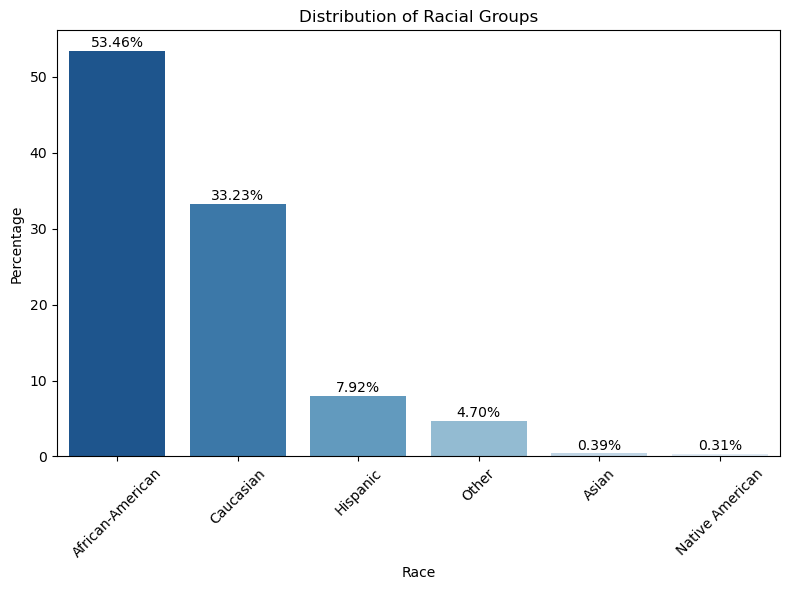

In [22]:
# Calculate percentage of each race
race_percentage = compas['race'].value_counts(normalize=True) * 100

# Sort races by count in descending order
race_percentage = race_percentage.sort_values(ascending=False)

# Visualize race distribution with percentage labels
plt.figure(figsize=(8, 6))
sns.barplot(x=race_percentage.index, y=race_percentage.values, palette="Blues_r")

# Add percentage labels to each bar
for i, val in enumerate(race_percentage.values):
    plt.text(i, val + 0.5, f"{val:.2f}%", ha="center")

plt.title('Distribution of Racial Groups')
plt.xlabel('Race')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The bar plot shows African-American had highest cases of 53.46% follow by Caucasia with 33.23% and Native American had the lowest cases of less than 1%.

African-American community is negatively skewed toward the higher risk.

Caucasian, Hispanic, Other and Asians are skew toward the lower risk.


In [23]:
compas.head(10)

,name,compas_screening_date,sex,dob,age,age_cat,race,decile_score,priors_count,c_jail_in,c_jail_out,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,is_violent_recid,type_of_assessment,score_text,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,days_in_jail
0,miguel hernandez,2013-08-14,1,18/04/1947,69,Greater than 45,Other,1,0,2013-08-13 06:03:00,2013-08-14 05:41:00,1.0,(F3),Aggravated Assault w/Firearm,0,0,Risk of Recidivism,Low,Risk of Violence,1,Low,2013-08-14,0.0
1,miguel hernandez,2013-08-14,1,18/04/1947,69,Greater than 45,Other,1,0,2013-08-13 06:03:00,2013-08-14 05:41:00,1.0,(F3),Aggravated Assault w/Firearm,0,0,Risk of Recidivism,Low,Risk of Violence,1,Low,2013-08-14,0.0
2,michael ryan,2014-12-31,1,06/02/1985,31,25 - 45,Caucasian,5,0,2013-02-04 07:24:00,2013-04-30 07:29:00,1.0,(F3),arrest case no charge,-1,0,Risk of Recidivism,Medium,Risk of Violence,2,Low,2014-12-31,0.0
3,kevon dixon,2013-01-27,1,22/01/1982,34,25 - 45,African-American,3,0,2013-01-26 03:45:00,2013-02-05 05:36:00,1.0,(F3),Felony Battery w/Prior Convict,1,1,Risk of Recidivism,Low,Risk of Violence,1,Low,2013-01-27,10.0
4,ed philo,2013-04-14,1,14/05/1991,24,Less than 25,African-American,4,4,2013-04-13 04:58:00,2013-04-14 07:02:00,1.0,(F3),Possession of Cocaine,1,0,Risk of Recidivism,Low,Risk of Violence,3,Low,2013-04-14,1.0
5,ed philo,2013-04-14,1,14/05/1991,24,Less than 25,African-American,4,4,2013-04-13 04:58:00,2013-04-14 07:02:00,1.0,(F3),Possession of Cocaine,1,0,Risk of Recidivism,Low,Risk of Violence,3,Low,2013-04-14,1.0
6,ed philo,2013-04-14,1,14/05/1991,24,Less than 25,African-American,4,4,2013-04-13 04:58:00,2013-04-14 07:02:00,1.0,(F3),Possession of Cocaine,1,0,Risk of Recidivism,Low,Risk of Violence,3,Low,2013-04-14,1.0
7,ed philo,2013-04-14,1,14/05/1991,24,Less than 25,African-American,4,4,2013-04-13 04:58:00,2013-04-14 07:02:00,1.0,(F3),Possession of Cocaine,1,0,Risk of Recidivism,Low,Risk of Violence,3,Low,2013-04-14,1.0
8,ed philo,2013-04-14,1,14/05/1991,24,Less than 25,African-American,4,4,2013-04-13 04:58:00,2013-04-14 07:02:00,1.0,(F3),Possession of Cocaine,1,0,Risk of Recidivism,Low,Risk of Violence,3,Low,2013-04-14,1.0
9,marcu brown,2013-01-13,1,21/01/1993,23,Less than 25,African-American,8,1,2013-02-04 07:24:00,2013-04-30 07:29:00,1.0,(F3),Possession of Cannabis,0,0,Risk of Recidivism,High,Risk of Violence,6,Medium,2013-01-13,0.0


In [24]:
df2=compas[['age', 'sex', 'race','decile_score', 'priors_count', 'days_in_jail', 'c_days_from_compas', 'is_violent_recid', 'v_decile_score','is_recid']]
df2.head()

,age,sex,race,decile_score,priors_count,days_in_jail,c_days_from_compas,is_violent_recid,v_decile_score,is_recid
0,69,1,Other,1,0,0.0,1.0,0,1,0
1,69,1,Other,1,0,0.0,1.0,0,1,0
2,31,1,Caucasian,5,0,0.0,1.0,0,2,-1
3,34,1,African-American,3,0,10.0,1.0,1,1,1
4,24,1,African-American,4,4,1.0,1.0,0,3,1


In [27]:
df2['race'].value_counts()

race
African-American    9791
Caucasian           6086
Hispanic            1451
Other                860
Asian                 71
Native American       57
Name: count, dtype: int64

In [33]:
filtered_df = df2[df2['race'].isin(['African-American', 'Caucasian', 'Hispanic'])]
X = filtered_df[['age', 'sex', 'decile_score', 'priors_count', 'race', 'days_in_jail', 'c_days_from_compas', 'is_violent_recid', 'v_decile_score']]
Y = filtered_df['is_recid']

In [34]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Create a copy of X to modify
X_encoded = X.copy() 
label_encoder = LabelEncoder()
X_encoded['race_encoded'] = label_encoder.fit_transform(X['race'])
X_s = X_encoded['race']  # Preserve the encoded race separately if needed
X_encoded.drop(['race'], axis=1, inplace=True)

# Splitting the Dataset for Training and Testing, including the sensitive attribute in the split to stratify
X_train, X_test, y_train, y_test, X_s_train, X_s_test = train_test_split(
    X_encoded, Y, X_s, test_size=0.2, stratify=X_encoded[['race_encoded']], random_state=42)


In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train a random forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=666)
clf.fit(X_train, y_train)  # Make sure X_train and y_train are correctly defined and formatted

# Predictions on the testing set
y_hat = clf.predict(X_test)  # Make sure X_test is properly prepared

# Evaluate the predictions
print("Accuracy on test set:", accuracy_score(y_test, y_hat))
print("Classification Report:\n", classification_report(y_test, y_hat))


Accuracy on test set: 0.8796884016156953
Classification Report:
               precision    recall  f1-score   support

          -1       0.64      0.59      0.61       151
           0       0.89      0.88      0.88      1704
           1       0.89      0.91      0.90      1611

    accuracy                           0.88      3466
   macro avg       0.81      0.79      0.80      3466
weighted avg       0.88      0.88      0.88      3466



In [36]:
import numpy as np

# Assuming y_hat and y_test are numpy arrays; if they are not, convert them:
# y_hat = np.array(y_hat)
# y_test = np.array(y_test)

# Calculate the confusion matrix components
TP = np.sum((y_hat == 1) & (y_test == 1))
FP = np.sum((y_hat == 1) & (y_test == 0))
TN = np.sum((y_hat == 0) & (y_test == 0))
FN = np.sum((y_hat == 0) & (y_test == 1))

# Calculate rates
TPR = TP / np.sum(y_test == 1)  # True Positive Rate
FPR = FP / np.sum(y_test == 0)  # False Positive Rate
TNR = TN / np.sum(y_test == 0)  # True Negative Rate
FNR = FN / np.sum(y_test == 1)  # False Negative Rate

# Print the rates
print('The true positive rate (Sensitivity, Recall) for the whole dataset is: {:.2f}'.format(TPR))
print('The false positive rate for the whole dataset is: {:.2f}'.format(FPR))
print('The true negative rate (Specificity) for the whole dataset is: {:.2f}'.format(TNR))
print('The false negative rate for the whole dataset is: {:.2f}'.format(FNR))


The true positive rate (Sensitivity, Recall) for the whole dataset is: 0.91
The false positive rate for the whole dataset is: 0.10
The true negative rate (Specificity) for the whole dataset is: 0.88
The false negative rate for the whole dataset is: 0.09


In [37]:
import numpy as np

# Assuming you have y_hat, y_test, and X_s_test already defined and prepared
# Convert to numpy arrays if they are not (if they are pandas Series or similar)
# y_hat = np.array(y_hat)
# y_test = np.array(y_test)
# X_s_test = np.array(X_s_test)  # Assuming this represents the 'race' groups

# Get unique groups
unique_groups = np.unique(X_s_test)

# Initialize dictionaries to store the rates for each race group
TPR = {}
FPR = {}
TNR = {}
FNR = {}

# Calculate metrics for each group
for group in unique_groups:
    TPR[group] = np.sum((y_hat == 1) & (y_test == 1) & (X_s_test == group)) / np.sum((y_test == 1) & (X_s_test == group))
    FPR[group] = np.sum((y_hat == 1) & (y_test == 0) & (X_s_test == group)) / np.sum((y_test == 0) & (X_s_test == group))
    TNR[group] = np.sum((y_hat == 0) & (y_test == 0) & (X_s_test == group)) / np.sum((y_test == 0) & (X_s_test == group))
    FNR[group] = np.sum((y_hat == 0) & (y_test == 1) & (X_s_test == group)) / np.sum((y_test == 1) & (X_s_test == group))

# Print the results
for group in unique_groups:
    print(f'The true positive rate (TPR) for {group} is: {TPR[group]:.2f}')
    print(f'The false positive rate (FPR) for {group} is: {FPR[group]:.2f}')
    print(f'The true negative rate (TNR) for {group} is: {TNR[group]:.2f}')
    print(f'The false negative rate (FNR) for {group} is: {FNR[group]:.2f}')
    print('---')  # Separator for clarity


The true positive rate (TPR) for African-American is: 0.92
The false positive rate (FPR) for African-American is: 0.13
The true negative rate (TNR) for African-American is: 0.85
The false negative rate (FNR) for African-American is: 0.07
---
The true positive rate (TPR) for Caucasian is: 0.90
The false positive rate (FPR) for Caucasian is: 0.07
The true negative rate (TNR) for Caucasian is: 0.91
The false negative rate (FNR) for Caucasian is: 0.10
---
The true positive rate (TPR) for Hispanic is: 0.79
The false positive rate (FPR) for Hispanic is: 0.05
The true negative rate (TNR) for Hispanic is: 0.93
The false negative rate (FNR) for Hispanic is: 0.18
---


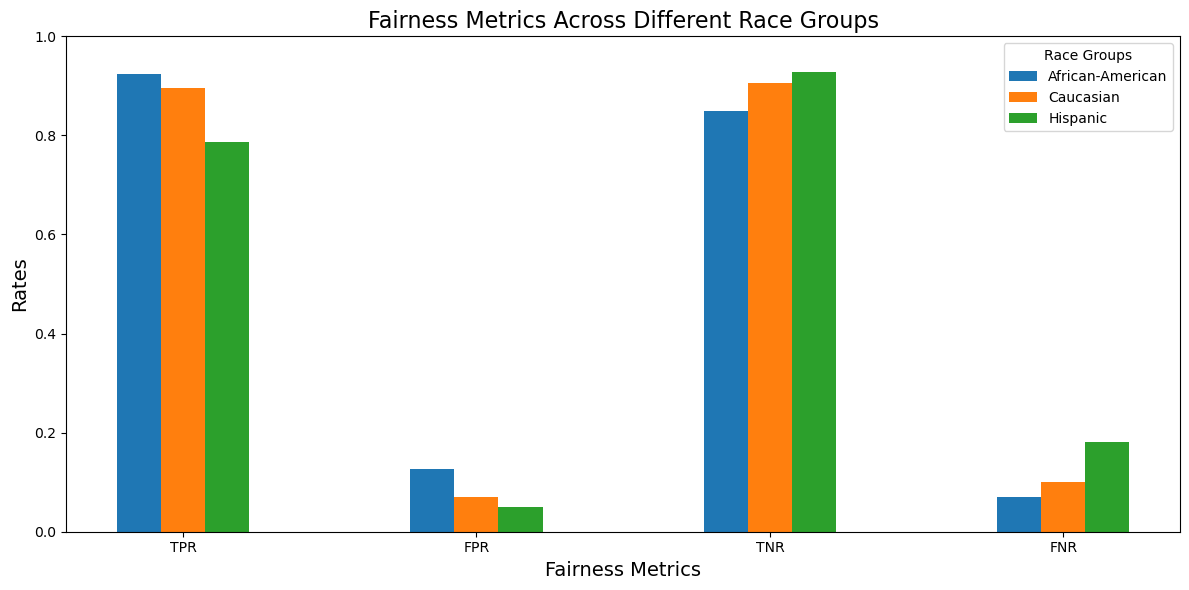

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Define metric names and ensure data is prepared as previously described
metric_names = ["TPR", "FPR", "TNR", "FNR"]
group_count = len(unique_groups)
bar_width = 0.15
indices = np.arange(len(metric_names))  # Position for each metric

# Create figure and axes
plt.figure(figsize=(12, 6))
ax = plt.subplot(111)

# Create bars for each group under each metric
for i, group in enumerate(unique_groups):
    # Extract metric values for this particular group
    group_metrics = [TPR[group], FPR[group], TNR[group], FNR[group]]
    # Offset each bar by the width times the number of groups already plotted
    ax.bar(indices + i * bar_width, group_metrics, bar_width, label=f'{group}')

# Customizing the plot with proper labels and titles
ax.set_xlabel('Fairness Metrics', fontsize=14)
ax.set_ylabel('Rates', fontsize=14)
ax.set_title('Fairness Metrics Across Different Race Groups', fontsize=16)
ax.set_xticks(indices + bar_width * (group_count / 2 - 0.5))
ax.set_xticklabels(metric_names)
ax.legend(title="Race Groups")

# Improving layout and aesthetics
plt.ylim(0, 1)  # Assume the rates are between 0 and 1
plt.xticks(rotation=0)  # Keep the metric names horizontal for clarity

# Show the plot
plt.tight_layout()
plt.show()


### Fairness Audit

### Measuring Predictive Parity 

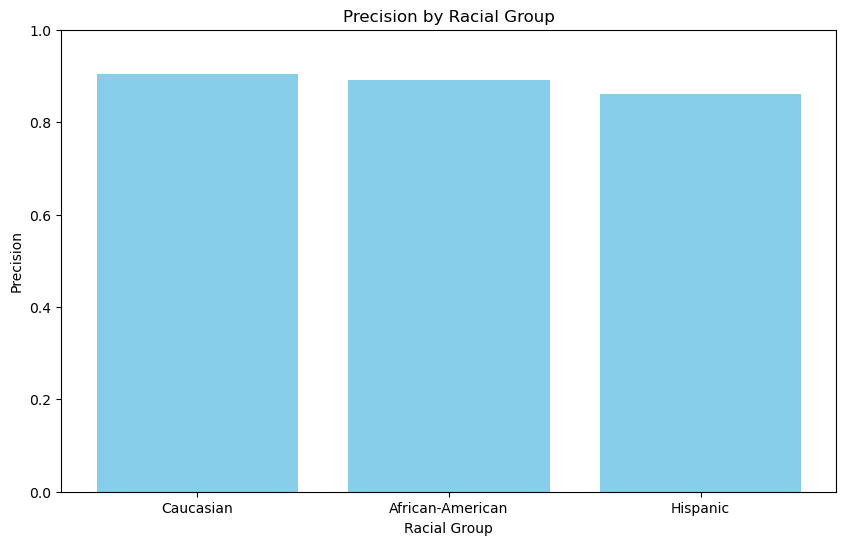

Violation of Predictive Parity!:
Caucasian vs African-American: 0.01
Caucasian vs Hispanic: 0.04
African-American vs Hispanic: 0.03


In [40]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

# Define the racial groups
racial_groups = ['Caucasian', 'African-American', 'Hispanic']

# Initialize a dictionary to store precision for each group
precisions = {}

# Calculate precision for each racial group
for group in racial_groups:
    tp_fp = np.sum((y_hat == 1) & (X_s_test == group))
    tp = np.sum((y_hat == 1) & (X_s_test == group) & (y_test == 1))
    precision = tp / tp_fp if tp_fp != 0 else 0
    precisions[group] = precision

# Convert precisions dictionary to DataFrame for better visualization
precision_df2 = pd.DataFrame(list(precisions.items()), columns=['Group', 'Precision'])

# Plotting the precision values
plt.figure(figsize=(10, 6))
plt.bar(precision_df2['Group'], precision_df2['Precision'], color='skyblue')
plt.xlabel('Racial Group')
plt.ylabel('Precision')
plt.title('Precision by Racial Group')
plt.ylim(0, 1)  # Precision ranges between 0 and 1
plt.show()

# Calculate violation of predictive parity for each combination of groups
violations = {}
for group_1, group_2 in itertools.combinations(racial_groups, 2):
    pred_parity_violation = abs(precisions[group_1] - precisions[group_2])
    violations[(group_1, group_2)] = pred_parity_violation

# Print the violations
print("Violation of Predictive Parity!:")
for groups, violation in violations.items():
    print(f"{groups[0]} vs {groups[1]}: {violation:.2f}")

### Measuring Equalized Odds(TPR and FPR)

                       TPR       FPR
Caucasian         0.895874  0.069984
African-American  0.924603  0.125993
Hispanic          0.787234  0.050000


<Figure size 1200x600 with 0 Axes>

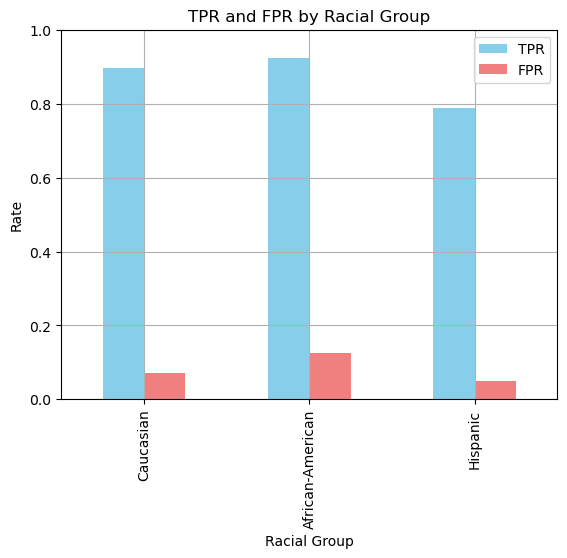

Violation of Equalized Odds for Race:
Caucasian vs African-American: TPR violation  0.03, FPR violation - 0.06
Caucasian vs Hispanic: TPR violation  0.11, FPR violation - 0.02
African-American vs Hispanic: TPR violation  0.14, FPR violation - 0.08


In [41]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

# Define the racial groups
racial_groups = ['Caucasian', 'African-American', 'Hispanic']

# Initialize dictionaries to store metrics for each group
metrics = {group: {'TPR': 0, 'FPR': 0} for group in racial_groups}

# Calculate TPR and FPR for each racial group
for group in racial_groups:
    tp = np.sum((y_hat == 1) & (X_s_test == group) & (y_test == 1))
    actual_positives = np.sum((X_s_test == group) & (y_test == 1))
    TPR = tp / actual_positives if actual_positives != 0 else 0
    
    fp = np.sum((y_hat == 1) & (X_s_test == group) & (y_test == 0))
    actual_negatives = np.sum((X_s_test == group) & (y_test == 0))
    FPR = fp / actual_negatives if actual_negatives != 0 else 0

    metrics[group]['TPR'] = TPR
    metrics[group]['FPR'] = FPR

# Convert metrics dictionary to DataFrame for better visualization
metrics_df2 = pd.DataFrame.from_dict(metrics, orient='index')
print(metrics_df2)

# Plotting TPR and FPR values
plt.figure(figsize=(12, 6))
metrics_df2.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('TPR and FPR by Racial Group')
plt.xlabel('Racial Group')
plt.ylabel('Rate')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

# Initialize a dictionary to store violations of equalized odds
equalized_odds_violations_race = {}

# Calculate violation for each combination of groups
for group_1, group_2 in itertools.combinations(racial_groups, 2):
    TPR_violation = abs(metrics[group_1]['TPR'] - metrics[group_2]['TPR'])
    FPR_violation = abs(metrics[group_1]['FPR'] - metrics[group_2]['FPR'])
    equalized_odds_violations_race[(group_1, group_2)] = (TPR_violation, FPR_violation)

# Print the violations
print("Violation of Equalized Odds for Race:")
for groups, violation in equalized_odds_violations_race.items():
    print(f"{groups[0]} vs {groups[1]}: TPR violation  {violation[0]:.2f}, FPR violation - {violation[1]:.2f}")


### Measuring Demographic Parity

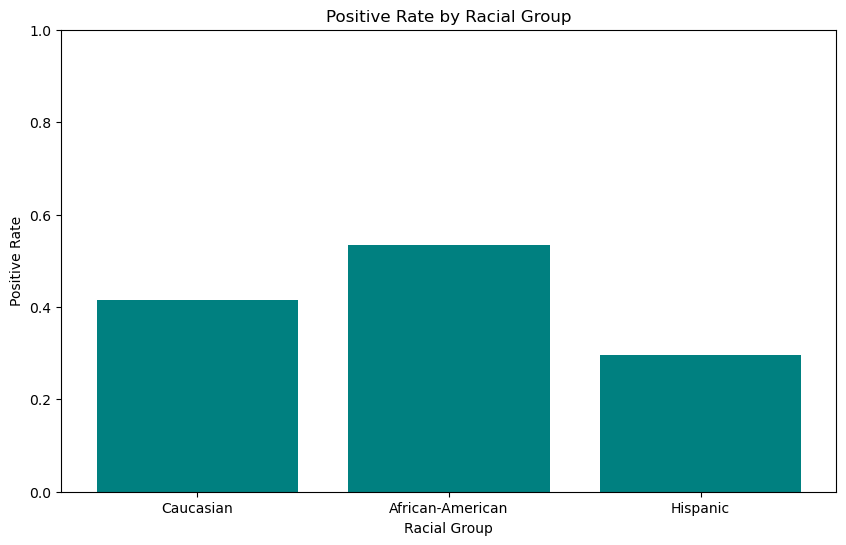

Violation of Demographic Parity for Race:
Caucasian vs African-American: 0.12
Caucasian vs Hispanic: 0.12
African-American vs Hispanic: 0.24


In [43]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

# Define the racial groups
racial_groups = ['Caucasian', 'African-American', 'Hispanic']

# Initialize dictionary to store metrics for each group
positive_rates = {group: 0 for group in racial_groups}

# Calculate positive rate for each racial group
for group in racial_groups:
    positives = np.sum((y_hat == 1) & (X_s_test == group))
    total = np.sum(X_s_test == group)
    positive_rate = positives / total if total != 0 else 0
    positive_rates[group] = positive_rate

# Convert positive rates dictionary to DataFrame for better visualization
positive_rates_df2 = pd.DataFrame(list(positive_rates.items()), columns=['Group', 'Positive Rate'])

# Plotting the positive rates
plt.figure(figsize=(10, 6))
plt.bar(positive_rates_df2['Group'], positive_rates_df2['Positive Rate'], color='teal')
plt.xlabel('Racial Group')
plt.ylabel('Positive Rate')
plt.title('Positive Rate by Racial Group')
plt.ylim(0, 1)  # Positive rate ranges between 0 and 1
plt.show()

# Initialize a dictionary to store violations of domestic parity
domestic_parity_violations_race = {}

# Calculate violation for each combination of groups
for group_1, group_2 in itertools.combinations(racial_groups, 2):
    positive_rate_violation = abs(positive_rates[group_1] - positive_rates[group_2])
    domestic_parity_violations_race[(group_1, group_2)] = positive_rate_violation

# Print the violations
print("Violation of Demographic Parity for Race:")
for groups, violation in domestic_parity_violations_race.items():
    print(f"{groups[0]} vs {groups[1]}: {violation:.2f}")

positive_rates_df2.set_index('Group',inplace=True)

### Conclusion:

1. African Americans have a higher FPR, and more individuals from this group may be unjustly subjected to harsher sentences or parole conditions
2. Caucasians have a higher FNR, which could mean that the system is underestimating the risk of recidivism in this group
3. The predictive alogorithm also fails to meet the  3 criteria (Predictive Parity, Equalized Odds and Demographic Parity) for fairness assessment of the model.

### Possible Mitigation Techniques:

1. Resampling of data to ensure equal representation of all communities.
2. Reweighting the under represented communities to avoid sampling bias.